In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import os 
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
import collections

from shutil import get_terminal_size

# Preprocessing

**Start by looking at the data**

In [30]:
df1 = pd.read_csv("details.csv"); #print(df1) 
df2 = pd.read_csv("details_fixed.csv"); #print(df2) 
df3 = pd.read_csv("payments.csv"); print(df3) 
df4 = pd.read_csv("profiling.csv"); print(df4) 

               ID  CountDeposit  CountWithdrawal  TotalDeposits  \
0       100001096            86               17           3218   
1       100002057            26                0            300   
2       100009325            76                9            558   
3       100014865            21                0            475   
4       100018655            45                3            915   
...           ...           ...              ...            ...   
207393  899973616            38                2            715   
207394  899987209           192               31           3882   
207395  899994536             1                1            100   
207396  899994603             1                0             10   
207397  899998254             5                0           1400   

        TotalWithdrawal  CountPaymentMethod  DifferentMethodWithdrawals  
0                  2622                   1                      2359.8  
1                     0                   1    

**Merge the datasets (by ID)**

In [31]:
df23 = df2.merge(df3,on = 'ID')
df234 = df23.merge(df4,on = 'ID'); print(df234.describe())

                 ID      Life_Time            Age      Is_Retail  \
count  2.073980e+05  207398.000000  207398.000000  207398.000000   
mean   5.008909e+08       2.603342      41.490410       0.410023   
std    2.306288e+08       3.122641      13.123745       0.491839   
min    1.000011e+08       0.000000      18.000000       0.000000   
25%    3.009800e+08       0.000000      31.000000       0.000000   
50%    5.018123e+08       1.000000      39.000000       0.000000   
75%    7.004120e+08       4.000000      51.000000       1.000000   
max    8.999983e+08      21.000000     120.000000       1.000000   

        Is_CRM_Email   CountDeposit  CountWithdrawal  TotalDeposits  \
count  207398.000000  207398.000000    207398.000000   2.073980e+05   
mean        0.418042      26.245721         2.734848   1.418705e+03   
std         0.493238      41.822574         7.559037   5.183685e+03   
min         0.000000       1.000000         0.000000   5.000000e+00   
25%         0.000000       4.000

**Check for missing values**

In [32]:
def missing(data):
    cols = data.columns 
    for (i,col) in enumerate(cols):
        print("Column %s  - missing values = " %(col), data[col].isnull().sum())
missing(df234)

Column ID  - missing values =  0
Column Life_Time  - missing values =  0
Column Age  - missing values =  0
Column Is_Retail  - missing values =  0
Column Is_CRM_Email  - missing values =  0
Column CountDeposit  - missing values =  0
Column CountWithdrawal  - missing values =  0
Column TotalDeposits  - missing values =  0
Column TotalWithdrawal  - missing values =  0
Column CountPaymentMethod  - missing values =  0
Column DifferentMethodWithdrawals  - missing values =  0
Column Multi_Device  - missing values =  0
Column IP_Counts  - missing values =  0
Column e_11234  - missing values =  0
Column e_23456  - missing values =  0
Column e_34454  - missing values =  0
Column e_43568  - missing values =  0
Column e_64645  - missing values =  0


**Nothing missing - add in the suspect player data**

In [33]:
## ADD SUSPECT PLAYERS
df5 = pd.read_csv("suspect.csv"); print(df5); print(df5.describe())
print(df234.loc[df234['ID'] == 100095464]) # LOOKS LIKE THESE ALREADY IN OTHER DATAFRAME

df2345 = pd.merge(df234, df5, how='outer', on='ID');
df2345['Target_ml'] = df2345['Target_ml'].replace(np.nan, 0)
df2345['Target_ml'] = df2345['Target_ml'].astype(int)
print(df2345); print(df2345.describe())

             ID  Target_ml
0     100095464          1
1     100333793          1
2     101329354          1
3     101607100          1
4     102590942          1
...         ...        ...
1747  898004908          1
1748  898448610          1
1749  899624336          1
1750  899737861          1
1751  899788191          1

[1752 rows x 2 columns]
                 ID  Target_ml
count  1.752000e+03     1752.0
mean   4.995049e+08        1.0
std    2.322098e+08        0.0
min    1.000955e+08        1.0
25%    2.941709e+08        1.0
50%    4.951482e+08        1.0
75%    6.985999e+08        1.0
max    8.997882e+08        1.0
           ID  Life_Time  Age  Is_Retail  Is_CRM_Email  CountDeposit  \
26  100095464          9   55          0             0           222   

    CountWithdrawal  TotalDeposits  TotalWithdrawal  CountPaymentMethod  \
26               38           5640             5200                   4   

    DifferentMethodWithdrawals  Multi_Device  IP_Counts  e_11234  e_23456  \

**Look at the feauture distributions**

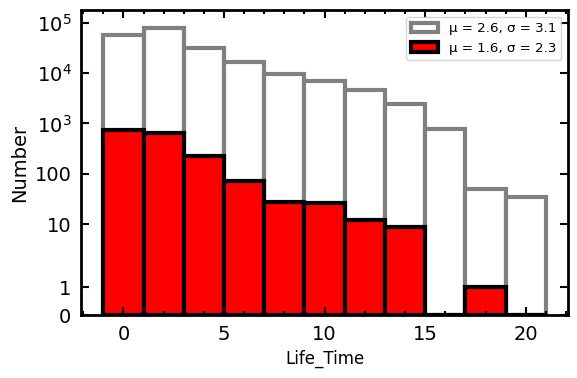

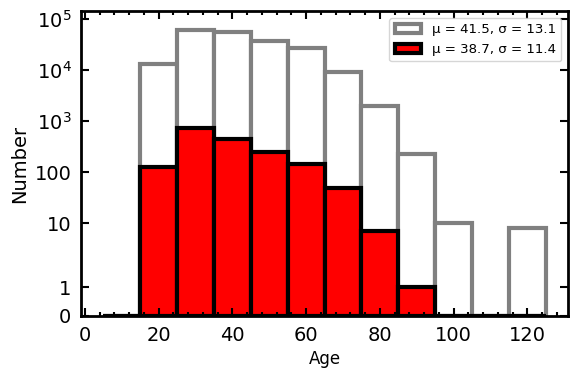

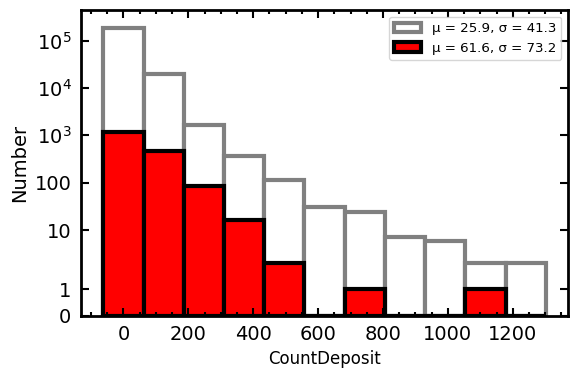

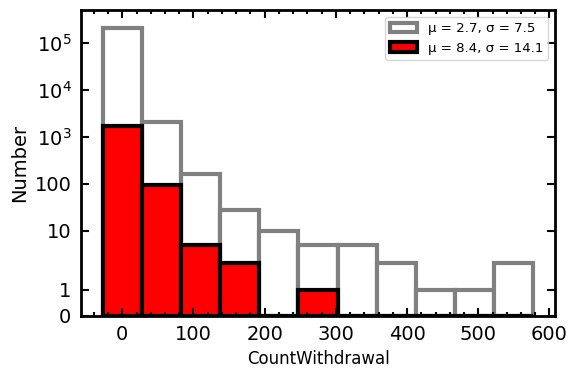

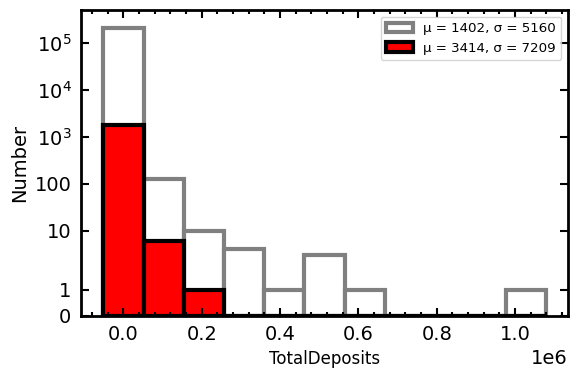

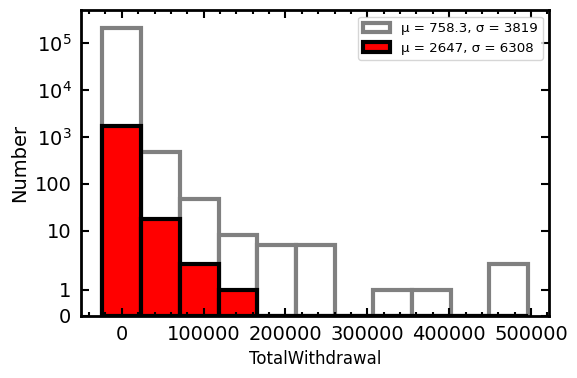

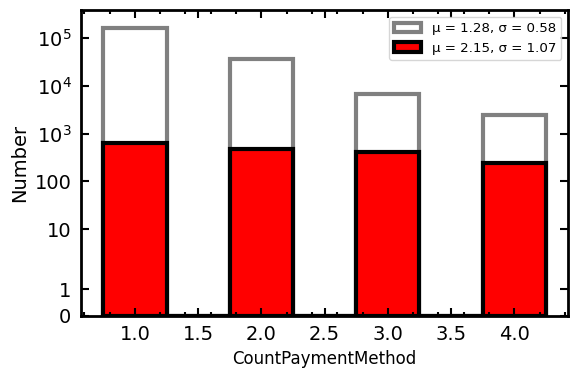

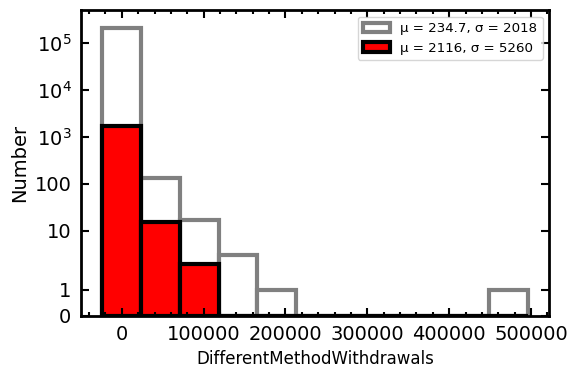

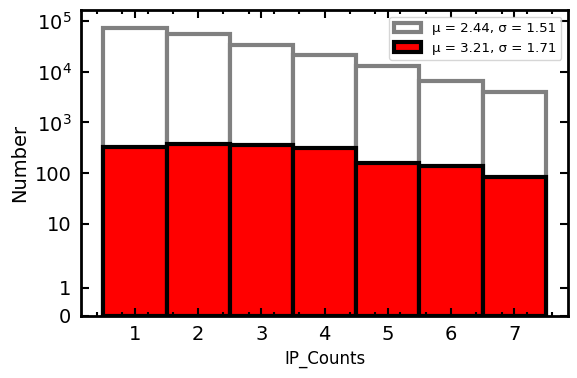

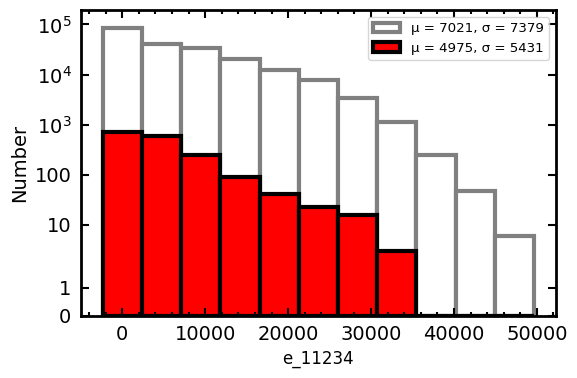

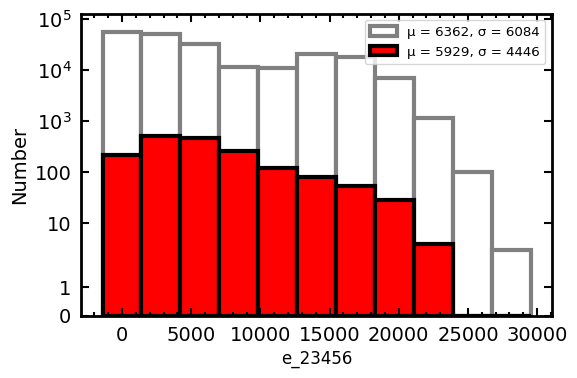

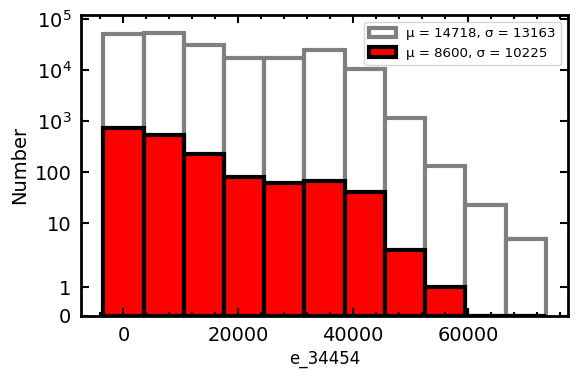

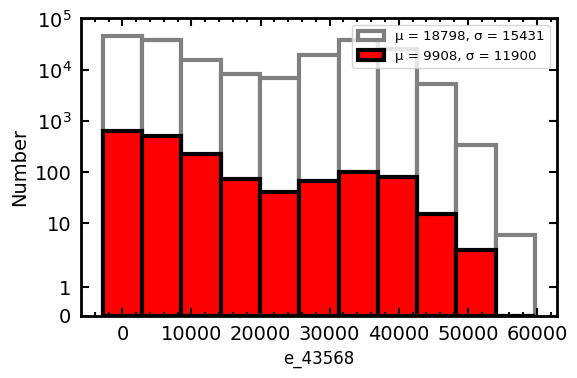

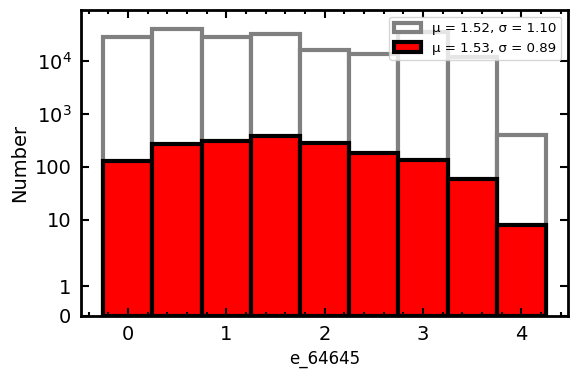

In [38]:
df = df2345.copy()
paras = ['Life_Time', 'Age', 'CountDeposit', 'CountWithdrawal', 'TotalDeposits', 'TotalWithdrawal', 'CountPaymentMethod', 'DifferentMethodWithdrawals', 'IP_Counts', 'e_11234', 'e_23456', 'e_34454', 'e_43568','e_64645']

for (i, para) in enumerate(paras):
   
    xmin = min(df[para]); 
    xmax = max(df[para]);
    
    if para == 'CountPaymentMethod':
        dbs = 0.5 # desired bin size
    elif para == 'IP_Counts':
        dbs = 1
    elif para == 'e_64645':
        dbs = 0.5
    else:
        dbs =  int((xmax-xmin)/10)
    
    data = df[para]
    min_val = np.min(data); max_val = np.max(data)
    min_boundary = -1.0 * (min_val % dbs - min_val)
    max_boundary = max_val - max_val % dbs + dbs
    n_bins = int((max_boundary - min_boundary) / dbs) + 1
    bins = np.linspace(min_boundary, max_boundary, n_bins)
    
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(6,4))
    ax = plt.gca()
    plt.setp(ax.spines.values(),linewidth=2)
    ax.tick_params(direction='in', pad = 7,length=6, width=1.5, which='major',right=True,top=True)
    ax.tick_params(direction='in', pad = 7,length=3, width=1.5, which='minor',right=True,top=True)

    text = '%s' %(para)
    plt.ylabel('Number', size=14); plt.xlabel(text, size=font)
    sus = df.loc[df['Target_ml'] == 1]
    non = df.loc[df['Target_ml'] == 0]; #print(len(sus),len(non))
    
    
    mean = np.mean(non[para]); std = np.std(non[para])

    ymin, ymax = plt.ylim(); #print(ymax)
         
    if xmax < 10:
        text = "\u03BC = %1.2f, \u03C3 = %1.2f" %(mean,std); xoff = 3.9
    elif xmax >10 and mean <= 100:
        text = "\u03BC = %1.1f, \u03C3 = %1.1f" %(mean,std); xoff = 2.9
    elif xmax >100 and mean <= 1000:
        text = "\u03BC = %1.1f, \u03C3 = %1.0f" %(mean,std);xoff = 2.5  
    elif xmax > 1000 and mean <= 10000:
        text = "\u03BC = %1.0f, \u03C3 = %1.0f" %(mean,std); xoff = 3.5
    else:
        text = "\u03BC = %1.0f, \u03C3 = %1.0f" %(mean,std); xoff = 2.5

    ax.hist(non[para], bins=bins-dbs/2, color="w", edgecolor='grey', linewidth=3, label = text);
  
    mean = np.mean(sus[para]); std = np.std(sus[para])
    if xmax < 10:
        text = "\u03BC = %1.2f, \u03C3 = %1.2f" %(mean,std); xoff = 3.9
    elif xmax >10 and mean < 100:
        text = "\u03BC = %1.1f, \u03C3 = %1.1f" %(mean,std); xoff = 2.9
    elif xmax >100 and mean < 1000:
        text = "\u03BC = %1.1f, \u03C3 = %1.0f" %(mean,std);xoff = 2.5  
    else:
        text = "\u03BC = %1.0f, \u03C3 = %1.0f" %(mean,std);xoff = 2.2
    
    ax.hist(sus[para], bins=bins-dbs/2, color="r", edgecolor='k', linewidth=3, label = text);
    
    ax.set_yscale('symlog');
    def update_ticks(z, pos):
        if z ==0:
            return '0'
        elif z >=1 and z <1000:
            return '%d' %(z)
        elif z < 1 and z > 0.001:
            return z
        else:
            return  '10$^{%1.0f}$' %(np.log10(z))
    
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(update_ticks))
    x_maj = ax.get_xticks()# MAJOR TICK SPACING
    x_min = (x_maj[1] -  x_maj[0])/5
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(x_min))
    ymin, ymax = plt.ylim(); 
    ax.set_ylim([ymin,1.2*ymax])
    ax.legend(fontsize = 0.8*font,loc="upper right")
    
    plt.tight_layout()
    plt.show()

# Machine learning

**Randomise and balance data**

In [14]:
## RANDOMISE
df = df.sample(frac=1)
df['Target_ml'] = df['Target_ml'].astype(int)

target = 'Target_ml'

## BALANCE DATASET
sus = df[df[target] == 1]; n1 = len(sus)
not_sus = df[df[target] == 0]; n0 = len(not_sus)

if n1 > n0:
    class0 = df.loc[df[target] == 0]
    class1 = df.loc[df[target] == 1][:n0]
else:
    class0 = df.loc[df[target] == 0][:n1]
    class1 = df.loc[df[target] == 1]
print("Sample sizes now", len(class0),len(class1))
df = pd.concat([class0, class1])

df = df.reindex(np.random.permutation(df.index))
df.reset_index(drop=True, inplace=True)
del df['ID']
#print(df)

Sample sizes now 1752 1752


**Split and standardise**

In [15]:
## SPLIT INTO TRAINING AND TEST
test_frac = 0.2
max_iter = 1000
n_neighbors = 26
max_depth = 6
cv = 10

## DROP TARGET
X = df.drop([target], axis = 1); y = df[target]
## SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_frac, random_state = 42)
## SCALE FEATURES - TRAIN AND TEST SEPERATELY
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

**Define classifiers and run these**

In [28]:
classifiers = {
    "LR": LogisticRegression(C=0.004832930238571752, solver='newton-cg'),
    "KNN": KNeighborsClassifier(n_neighbors=n_neighbors),
    "SVC": SVC(C=1, gamma=0.1,probability=True),
    "DTR": DecisionTreeClassifier(max_depth = max_depth),
}

cal = str(input("Show calibration plots [y/n]?  "))

fea = str(input("Show feature importance [y/n]?  "))

for key, classifier in classifiers.items():
    clf = classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=cv) 
    print("For a %1.1f test fraction (%d train & %d test) %s score = %1.3f" %(test_frac, len(X_train), len(X_test), key, training_score.mean()*100))

    predictions = classifier.predict(X_test); #print('Testing\n', confusion_matrix(predictions, y_test))
    TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()
    print('Validation accuracy of %s is %1.2f percent' %(key, 100*(TP + TN)/(TP + FP + TN + FN)))

    #### CALIBRATION PLOTS ######
    if (cal =='y') | (cal == 'Y'):
        from sklearn.calibration import CalibrationDisplay
        nbins= 20
        strat='quantile'
        #strat = 'uniform'
        font = 12

        plt.rcParams.update({'font.size': font})
        fig, ax1 = plt.subplots(figsize = (6, 4))
        #ax2 = fig.add_axes([0.55, 0.2, 0.35, 0.3]) # INSET left, bottom, width, height
        ax2 = fig.add_axes([0.15, 0.6, 0.35, 0.3])
        ax2.yaxis.set_label_position("right"); ax2.yaxis.tick_right()
        plt.setp(ax1.spines.values(),linewidth=2)
        plt.setp(ax2.spines.values(),linewidth=2)
        ax1.tick_params(direction='in', pad = 5,length=6, width=1.5, which='major')
        ax1.tick_params(direction='in', pad = 5,length=3, width=1.5, which='minor')
        ax2.tick_params(axis='both', which='major', labelsize=0.8*font)
    
        disp = CalibrationDisplay.from_estimator(clf,X_test,y_test,n_bins=nbins,strategy=strat,
                                                 pos_label=None, color='r', name=key, ref_line=True,
                                                 ax=ax1,zorder = 2, label = r"%s, $n = %d$" %(key,len(X_test)))

        ax2.hist(disp.y_prob,range=(0,1),bins=nbins,label=key, color="silver", edgecolor='k',lw=2,zorder=1,alpha=0.7)
        #ax2.set_xlabel(r'Mean predicted probability', size=0.8*font);
        ax2.set_ylabel(r'Number',size=0.8*font)
    
        #print(disp.y_prob); print(disp.prob_pred); print(disp.prob_true)
        diff2  = (disp.prob_pred - disp.prob_true)**2; 
        diff2_sum = diff2.sum(); print(diff2_sum)
        ax1.plot([], [], ' ', label=r"$\chi^2/n_{\rm bins} = %1.3f$" %(diff2_sum/(nbins)))# Extra label on the legend
        ax1.legend(fontsize = font,loc='lower right',labelcolor='k')

        plt.tight_layout()
        outfile = 'cal_display_%s-nbins=%d.eps' %(key,nbins)
        #plt.savefig(outfile, format = 'eps'); print('Written to %s' %(outfile))
        plt.show()
    
    if (fea =='y') | (fea == 'Y'):
        #FEATURE IMPORTANCE #########
        from sklearn.inspection import permutation_importance
        results = permutation_importance(classifier, X_train, y_train, scoring='accuracy')
        importance = results.importances_mean
        features = df.drop(target,axis = 1) 
        features = features.columns.tolist()
        df1 = pd.DataFrame(features, columns=['Feature']); 
        df2 = pd.DataFrame(importance, columns=['Importance'])
        df1['Importance'] = df2.Importance  # adding to df1
        print(df1.sort_values(by=['Importance'], ascending=False)) 
        print('------------------------------------------------------')

Show calibration plots [y/n]?  n
Show feature importance [y/n]?  y
For a 0.2 test fraction (2803 train & 701 test) LR score = 75.956
Validation accuracy of LR is 77.32 percent
                       Feature  Importance
8              TotalWithdrawal    0.060364
15                     e_34454    0.030681
16                     e_43568    0.023189
11                Multi_Device    0.017838
13                     e_11234    0.012986
9           CountPaymentMethod    0.010203
12                   IP_Counts    0.009133
14                     e_23456    0.007920
4                 Is_CRM_Email    0.005280
3                    Is_Retail    0.004210
1                    Life_Time    0.003924
2                          Age    0.003710
6              CountWithdrawal    0.003639
10  DifferentMethodWithdrawals    0.003496
7                TotalDeposits    0.002925
0                           ID    0.002854
5                 CountDeposit    0.000428
17                     e_64645         NaN
-------